In [ ]:
import pandas as pd
from ast import literal_eval
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
import random

In [ ]:
# -TASK 1-

# Load the dataset
file_url = 'https://raw.githubusercontent.com/Kent0n-Li/ChatDoctor/refs/heads/main/format_dataset.csv'
df = pd.read_csv(file_url)

# Print a few rows to visualize the data
print("Sample of the dataset:")
print(df.head())
print('\n---------------------------------------------------------\n')

# Check for null data
print("Null data:")
print(df.isnull().sum())

Sample of the dataset:
   idx                           disease  \
0    0                    Panic disorder   
1    1                  Vocal cord polyp   
2    2                   Turner syndrome   
3    3                    Cryptorchidism   
4    4  Poisoning due to ethylene glycol   

                                             Symptom  \
0  ['Anxiety and nervousness', 'Depression', 'Sho...   
1  ['Hoarse voice', 'Sore throat', 'Difficulty sp...   
2  ['Groin mass', 'Leg pain', 'Hip pain', 'Suprap...   
3  ['Symptoms of the scrotum and testes', 'Swelli...   
4  ['Abusing alcohol', 'Fainting', 'Hostile behav...   

                                              reason  \
0  Panic disorder is an anxiety disorder characte...   
1                     beclomethasone nasal product,    
2  Turner syndrome or Ullrich\xe2\x80\x93Turner s...   
3  Cryptorchidism (derived from the Greek \xce\xb...   
4                                         thiamine,    

                                  Test

In [ ]:
# Convert string representations of lists to actual lists
def convert_to_list(column):
    return df[column].apply(lambda x: literal_eval(x) if isinstance(x, str) else [])

df['Symptom'] = convert_to_list('Symptom')
df['TestsAndProcedures'] = convert_to_list('TestsAndProcedures')
df['commonMedications'] = convert_to_list('commonMedications')

texts = []
labels = []

# Extracting
diseases = df['disease'].dropna().unique()
texts.extend(diseases)
labels.extend(['disease'] * len(diseases))


symptoms = df['Symptom'].explode().dropna().unique()
texts.extend(symptoms)
labels.extend(['symptom'] * len(symptoms))


tests = df['TestsAndProcedures'].explode().dropna().unique()
texts.extend(tests)
labels.extend(['tests'] * len(tests))


medications = df['commonMedications'].explode().dropna().unique()
texts.extend(medications)
labels.extend(['medication'] * len(medications))

In [ ]:
data = pd.DataFrame({
    'text': texts,
    'class': labels
})

print("Initial class distribution:")
print(data['class'].value_counts())

Initial class distribution:
class
medication    1289
disease        796
symptom        376
tests          171
Name: count, dtype: int64


In [ ]:
# Target oversampling size (maximum class size)
target_size = data['class'].value_counts().max()
print(f"\nTarget class size for oversampling: {target_size}")

classes = data['class'].unique()
df_list = [data[data['class'] == cls] for cls in classes]

# Oversample each class to the target size (with replacement)
oversampled_dfs = []
for df_class in df_list:
    if len(df_class) < target_size:
        df_class_oversampled = resample(
            df_class,
            replace=True,
            n_samples=target_size,
            random_state=42
        )
        oversampled_dfs.append(df_class_oversampled)
    else:
        oversampled_dfs.append(df_class)

# Combine oversampled data
balanced_data = pd.concat(oversampled_dfs).reset_index(drop=True)

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


print("\nBalanced class distribution:")
print(balanced_data['class'].value_counts())

print("\nSample of balanced dataset:")
print(balanced_data.head())


Target class size for oversampling: 1289

Balanced class distribution:
class
tests         1289
disease       1289
medication    1289
symptom       1289
Name: count, dtype: int64

Sample of balanced dataset:
                                                text       class
0                     Radiographic imaging procedure       tests
1                                         Tendinitis     disease
2  Other non-OR therapeutic procedures on skin an...       tests
3                       Removal of ectopic pregnancy       tests
4                                 Calcitriol Topical  medication


In [ ]:
# -TASK 2 & 3-        (Visualizations(Confusion Matrixes) are added after each model evaluation)

# Encoding the Target Variable
le = LabelEncoder()
balanced_data['class_encoded'] = le.fit_transform(balanced_data['class'])

X = balanced_data['text']
y = balanced_data['class_encoded']

# Train-Test split -> 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTrain set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model_performance = []


Train set size: 4124
Test set size: 1032


In [ ]:
# The method for Evaluation step (will be used in all models)
def evaluate_model(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n================== {model_name} ==================\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return precision, recall, f1


================== Support Vector Machine (SVM) ==================

Classification Report:
              precision    recall  f1-score   support

     disease       0.61      0.96      0.74       258
  medication       0.99      0.38      0.55       258
     symptom       0.97      1.00      0.98       258
       tests       0.99      1.00      0.99       258

    accuracy                           0.83      1032
   macro avg       0.89      0.83      0.82      1032
weighted avg       0.89      0.83      0.82      1032

Precision: 0.8888
Recall:    0.8333
F1-Score:  0.8172


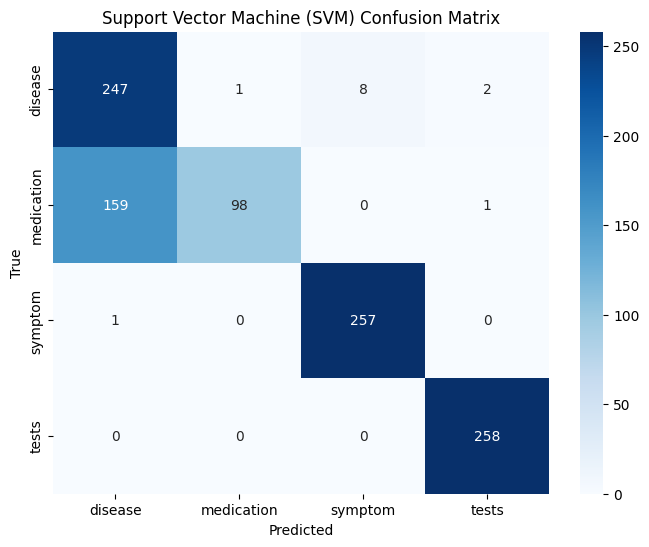

In [ ]:
# 1) SUPPORT VECTOR MACHINE(SVM)

# Pipeline for SVM: TF-IDF Vectorizer -> Standard Scaler -> SVM Classifier
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
                          ('scaler', StandardScaler(with_mean=False)),
                           ('svm', SVC(kernel='linear', C=1, gamma='auto', random_state=42))
                           ])

# Train the SVM model
svm_pipeline.fit(X_train, y_train)

# Evaluate SVM and collect metrics
class_names = le.classes_
svm_precision, svm_recall, svm_f1 = evaluate_model(svm_pipeline, X_test, y_test, class_names, "Support Vector Machine (SVM)")
model_performance.append({
    'Model': 'Support Vector Machine (SVM)',
    'Precision': svm_precision,
    'Recall': svm_recall,
    'F1-Score': svm_f1
})


================== Naive Bayes ==================

Classification Report:
              precision    recall  f1-score   support

     disease       0.59      0.91      0.72       258
  medication       0.98      0.38      0.55       258
     symptom       0.96      0.98      0.97       258
       tests       0.97      1.00      0.98       258

    accuracy                           0.82      1032
   macro avg       0.87      0.82      0.80      1032
weighted avg       0.87      0.82      0.80      1032

Precision: 0.8737
Recall:    0.8198
F1-Score:  0.8047


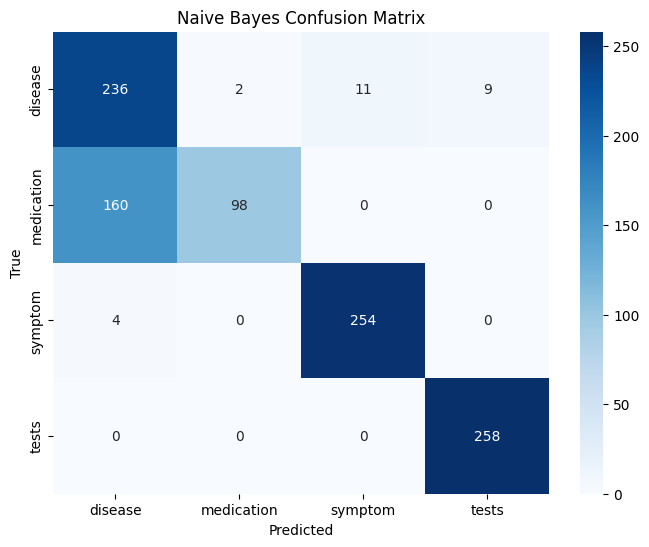

In [ ]:
# 2) NAIVE BAYES

# MultinomialNB works well with count data or TF-IDF features
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
                        ('nb', MultinomialNB())])

# Train the Naive Bayes model
nb_pipeline.fit(X_train, y_train)

# Evaluate Naive Bayes and collect metrics
nb_precision, nb_recall, nb_f1 = evaluate_model(nb_pipeline, X_test, y_test, class_names, "Naive Bayes")
model_performance.append({
    'Model': 'Naive Bayes',
    'Precision': nb_precision,
    'Recall': nb_recall,
    'F1-Score': nb_f1
})


================== Random Forest ==================

Classification Report:
              precision    recall  f1-score   support

     disease       0.99      0.85      0.92       258
  medication       0.90      1.00      0.94       258
     symptom       0.97      0.99      0.98       258
       tests       1.00      1.00      1.00       258

    accuracy                           0.96      1032
   macro avg       0.96      0.96      0.96      1032
weighted avg       0.96      0.96      0.96      1032

Precision: 0.9631
Recall:    0.9603
F1-Score:  0.9597


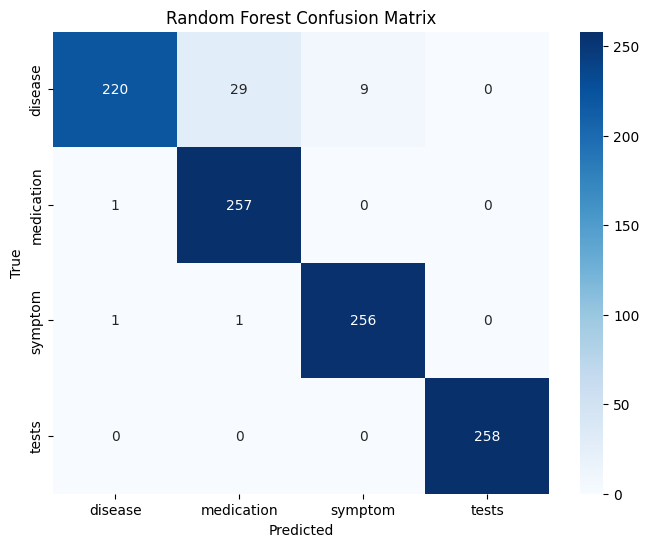

In [ ]:
# 3) RANDOM FOREST

# Random Forests generally require dense input; TF-IDF vectors are already suitable
rf_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
                        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
                        ])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Evaluate Random Forest and collect metrics
rf_precision, rf_recall, rf_f1 = evaluate_model(rf_pipeline, X_test, y_test, class_names, "Random Forest")
model_performance.append({
    'Model': 'Random Forest',
    'Precision': rf_precision,
    'Recall': rf_recall,
    'F1-Score': rf_f1
})

---


================== Model Performance Comparison ==================
                          Model  Precision    Recall  F1-Score
0  Support Vector Machine (SVM)   0.888774  0.833333  0.817222
1                   Naive Bayes   0.873696  0.819767  0.804747
2                 Random Forest   0.963125  0.960271  0.959688




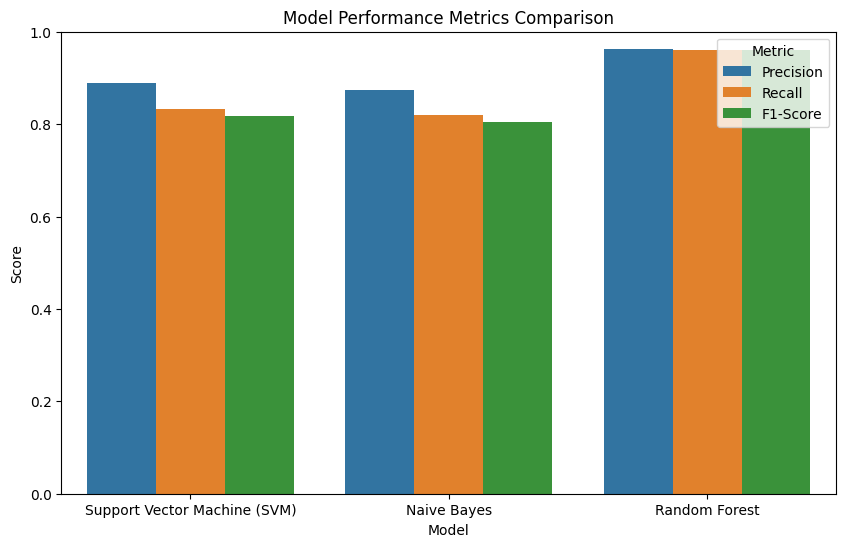

In [ ]:
# Dataframe for comparison
performance_df = pd.DataFrame(model_performance)
print("\n================== Model Performance Comparison ==================")
print(performance_df)
print("\n")

performance_df.set_index('Model', inplace=True)
performance_df_reset = performance_df.reset_index()

# Bar Plot for each metric
performance_melted = performance_df_reset.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=performance_melted)
plt.title('Model Performance Metrics Comparison')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.show()

---
## **Model Comparison and Performance**

The performance of the following algorithms is compared: **Random Forest**, **Support Vector Machine (SVM)**, and **Naive Bayes**. The key observations from this study are listed below:

### 1. Random Forest
- **Performance**: Achieved the highest F1-score among the models, proving it provided the best classification performance across all classes. It outperformed both SVM and Naive Bayes in Precision, Recall, and F1-Score.
- **Advantages**:
  - Captures complex feature interactions using ensemble learning.
  - Reduces overfitting by averaging across many decision trees.
  - Handles large datasets and high-dimensional spaces effectively.
  - Provides insights into feature importance.
- **Disadvantages**:
  - Slower training compared to simpler models.
  - Less interpretable than Naive Bayes.

### 2. Support Vector Machine (SVM)
- **Performance**: Performed slightly better than Naive Bayes but below Random Forest. It handled high-dimensional data effectively and achieved high precision and recall for classes with clear separation.
- **Advantages**:
  - Performs well in high-dimensional spaces.
  - Suitable for datasets with a clear margin of separation.
- **Disadvantages**:
  - Computationally intensive for large datasets.
  - Highly dependent on kernel selection and hyperparameter tuning.

### 3. Naive Bayes
- **Performance**: Served as a strong baseline model with competitive precision and recall but was outperformed by Random Forest and SVM in overall metrics. Its assumption of feature independence limited its capacity to model complex relationships.
- **Advantages**:
  - Simple to train and fast.
  - Naturally handles multi-class classification.
  - Efficient for large feature spaces.
- **Disadvantages**:
  - Assumes feature independence, which is often unrealistic in real-world data.
  - Performs poorly with correlated features.

---

## **Conclusion and Recommendations**
- **Random Forest** consistently outperformed the other models due to its ability to model non-linear relationships and complex feature interactions, while generalizing well to unseen data. It is recommended as the most effective model for this task.
- **SVM** showed solid performance and is particularly suitable for high-dimensional data with well-separated classes but requires significant fine-tuning for optimal results.
- **Naive Bayes** is a computationally efficient and easy-to-implement baseline model, offering respectable performance despite its simplifying assumptions.

### **Final Recommendation**
- For tasks where **accuracy and robust performance** are critical, **Random Forest** is the best choice.
- For tasks requiring **computational efficiency** or **interpretability**, we can consider **Naive Bayes** or **SVM** based on the specific requirements.